<a href="https://www.kaggle.com/code/dalloliogm/bank-autogluon?scriptVersionId=253661034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

How to improve this notebook:
- add more feature engineering
- Try different autogluon presets
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [7]:
# %%capture
# !pip install -U autogluon

In [12]:
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [14]:

!cp -r /kaggle/input/autogluon-package/* /kaggle/working/
!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


Looking in links: --quiet, /kaggle/input/autogluon-package
Processing ./autogluon.tabular-1.3.1-py3-none-any.whl
Processing /kaggle/input/autogluon-package/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.core-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.features-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.common-1.3.1-py3-none-any.whl (from autogluon.core==1.3.1->autogluon.tabular==1.3.1)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encode

In [16]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   0.2,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

Interactive session
{'autogluon_time': 100, 'autogluon_preset': 'medium_quality', 'tail_rows': 2000}


In [17]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [18]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    # 'TABPFN': {},
    'ENS_WEIGHTED' : {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED', 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [19]:
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [20]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [21]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


# Set up Training

In [22]:
# 2) Fit all models under regression:
predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train,
    hyperparameters=hyperparameters,
    time_limit = config["autogluon_time"],
    presets = config["autogluon_preset"]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250801_104402"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.88 GB / 31.35 GB (95.3%)
Disk Space Avail:   16.00 GB / 19.52 GB (82.0%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "/kaggle/working/AutogluonModels/ag-20250801_104402"
Train Data Rows:    2000
Train Data Columns: 16
Label Column:       y
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30597.65 MB
	Train Data (Original)  Memory Usage: 1.1

In [29]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.946911,roc_auc,0.286436,13.900803,0.000839,0.051675,2,True,8
1,CatBoost,0.941643,roc_auc,0.006400,3.141841,0.006400,3.141841,1,True,4
2,LinearModel,0.940814,roc_auc,0.018163,2.952337,0.018163,2.952337,1,True,7
3,RandomForest,0.936879,roc_auc,0.132858,1.131442,0.132858,1.131442,1,True,3
4,XGBoost,0.933061,roc_auc,0.008493,0.482225,0.008493,0.482225,1,True,6
5,ExtraTrees,0.932232,roc_auc,0.122801,1.083920,0.122801,1.083920,1,True,5
6,LightGBM,0.924716,roc_auc,0.005376,5.539587,0.005376,5.539587,1,True,2
7,KNeighbors,0.773023,roc_auc,0.008034,4.978526,0.008034,4.978526,1,True,1


# Save Submission

In [23]:
preds = predictor.predict_proba(test)
preds

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,0,1
id,,
750000,0.982943,0.017057
750001,0.786860,0.213140
750002,0.992889,0.007111
750003,0.997013,0.002987
750004,0.930696,0.069304
...,...,...
999995,0.998699,0.001301
999996,0.890830,0.109170
999997,0.582666,0.417334


In [24]:
preds = predictor.predict_proba(test)[1]  # Probability for class 1
submission['y'] = preds

# Save submission
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

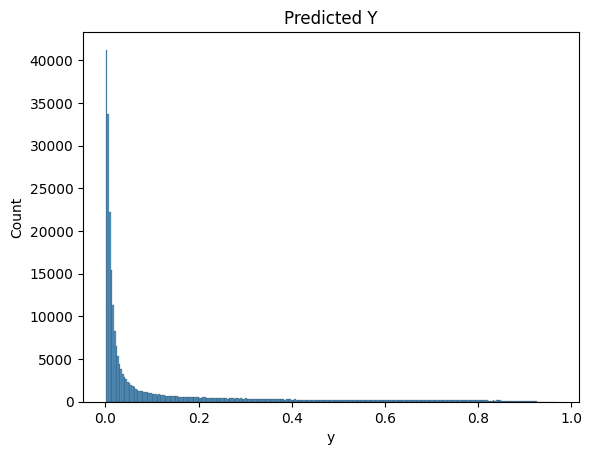

In [30]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

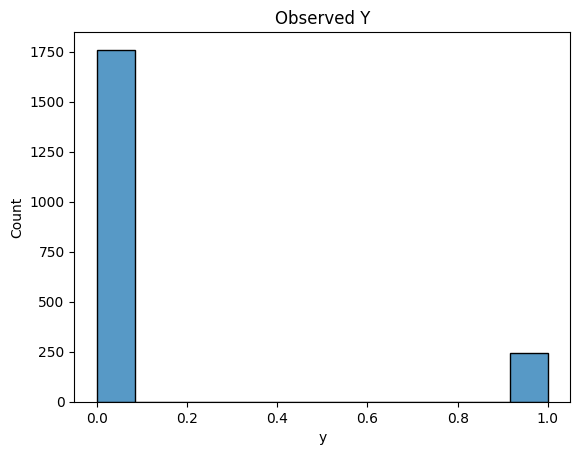

In [31]:
sns.histplot(train.y).set_title("Observed Y")